# Дисклеймер
Это не оформление в Юпитере!
Это питоновский код, запущенный в 1 строчку юпитера, потому что в VS Code анимация показывает несколько кадров анимации, а потом зависает, в то время как юпитер это запускает
Однако на Юпитер переписывать не хочу, потому юпитер не подставляет сам названия функций длиной в полсухотные границы России, и 
там нет отладки кода

<IPython.core.display.Javascript object>


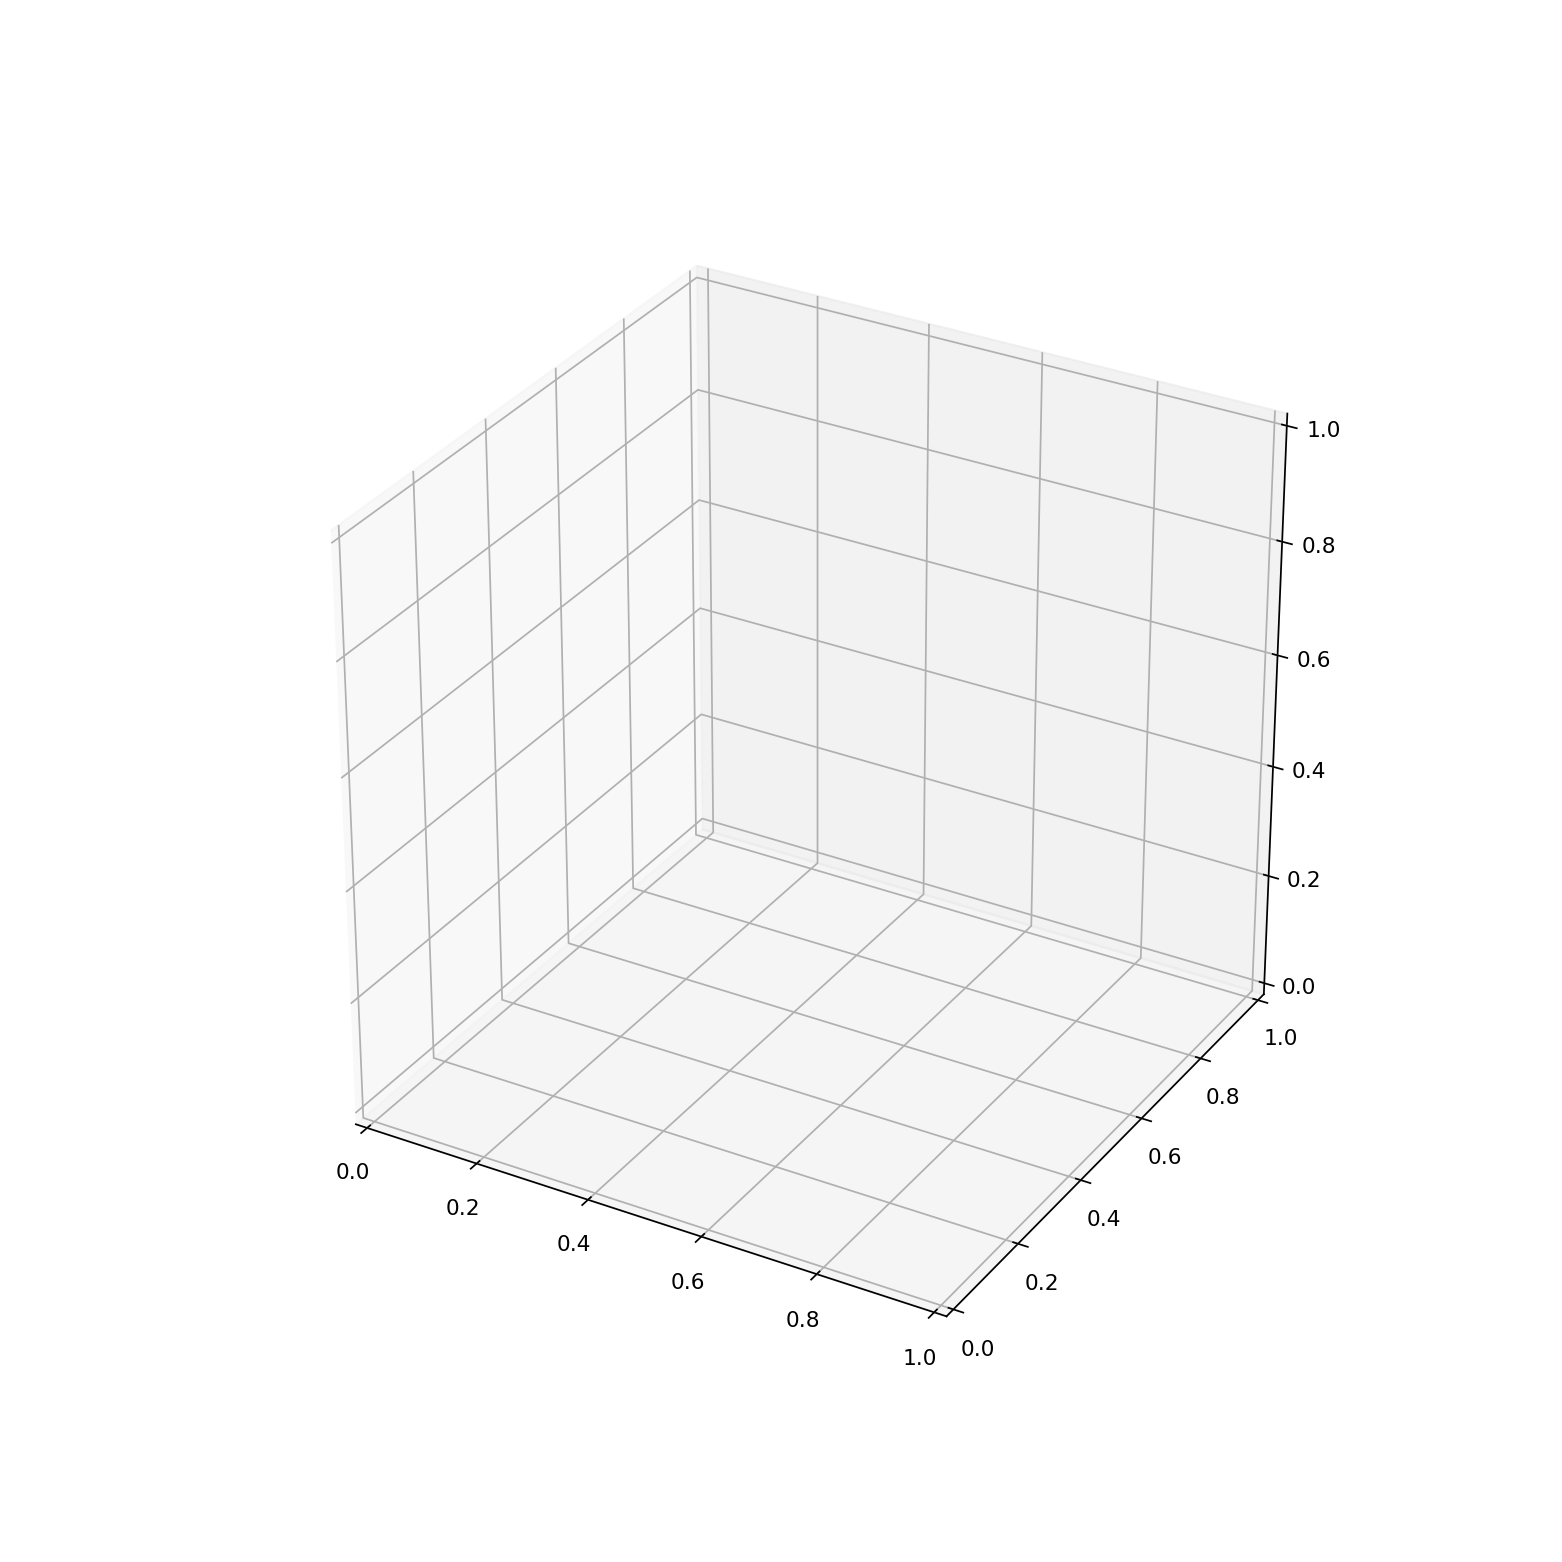

RuntimeError: cannot cache function 'calc_acceleration': no locator available for file 'C:\\Users\\05E9~1\\AppData\\Local\\Temp/ipykernel_17076/4170346288.py'

In [9]:
import matplotlib.pyplot as plt 
import numpy as np 
from numpy.linalg import norm 
import random as rd
import unittest
import numba as nb

# Магическая строка для корректного отображения анимации
%matplotlib notebook

G = 4 * np.pi**2 # в системе единиц "годы, массы Солнца, а.е."
dt = 0.005
crash_distance = 0.001
#total_
total_time = 10 #в годах
dim = 3 #размерность задачи
destroy_flag = 0 
vmax = 3 #максимальная скорость моделируемых тел
radius = 2 #максимальное расстояние от начала координат для моделируемых тел
size = 5 #radius * 3
max_dist = 10

fig = plt.figure(figsize=(10, 10))
# Добавляем на нее объект Axes3D для отображения графиков в 3D
ax = fig.add_subplot(111, projection='3d')
time = 0
        
#единственная функция, где на мой взгляд стоит использовать numba, в остальных, 
#чтобы к атрибуту класса вектор, кажется, нет смысла писать отдельную функцию и ускорять ее
@nb.njit('float64[:](float64,float64[:],float64[:])', cache=True,
         nogil=False, fastmath=True, parallel=False) 
def calc_acceleration(mass, r_0, r = np.array([0,0,0])):
    return G * mass * (r_0 - r) / (norm(r - r_0)**3)

class Star():
    def __init__(self, mass = None, vec_r = None, vec_v = None): #, dv=0):
        self.mass = mass if mass is not None else rd.uniform(1,10)
        self.vec_r = np.array(vec_r) if vec_r is not None else np.array(rd.uniform(-radius,radius, size=dim) )
        self.vec_v = np.array(vec_v) if vec_v is not None else np.array(rd.uniform(-vmax,vmax, size=dim))
         #self.dv = dv #np.array(dv)
    
    def show(self):
        print(f'm = {self.mass}, vec_r = {self.vec_r}, vec_v = {self.vec_v}')

    def is_body(self, body):
        res = 1
        for i in range(dim):
            res = res & (self.vec_r[i] == body.vec_r[i]) & (self.vec_v[i] == body.vec_v[i]) 
            #print(self.vec_r[i], body.vec_r[i], self.vec_v[i], body.vec_r[i])
        res = (self.mass == body.mass) & res #& (self.dv ==  body.dv)
        #print(res)
        return res

    def destroy(self, body):
        if (self.mass / body.mass < 1e4):
            self.vec_r = (self.vec_r + body.vec_r)/2
            self.vec_v = (self.mass * self.vec_v + body.mass * body.vec_r) / (self.mass + body.mass)       
            self.mass = self.mass + body.mass

    def move_system(self, bodies, time):
        if ((norm(self.vec_v) > 0)or(norm(self.vec_r)>0)): #проверка того, перешли ли мы уже в СО звезды
            for body in bodies:
                body.vec_v = body.vec_v - self.vec_v # переход в СО звезды
                body.vec_r = body.vec_r - self.vec_r
            self.vec_v = self.vec_v * 0
            self.vec_r = self.vec_r * 0
            
        self_destroy_flag = 0
        destroy_flag = 0
        
        #найдем ускорение самой звезды 
        self_dv = self.vec_v * 0  #для соблюдения размерности
        for obj in bodies:
            if (norm(obj.vec_r-self.vec_r) > crash_distance):
                if (self.mass / obj.mass < 1e4):
                    self_dv = self_dv + calc_acceleration(obj.mass, obj.vec_r, ) #G * obj.mass * obj.vec_r  / (norm(obj.vec_r)**3)
            else:
                self_destroy_flag = 1
                destroyed_obj = obj
                break

        if (self_destroy_flag == 1):
            #new_list_of_bodies = [elem for elem in bodies if (not elem.is_body(destroyed_obj))] 
            self.destroy(destroyed_obj)
            #print(f'1 body crashed on a star, modeling {len(new_list_of_bodies)} bodies')
            #self.gravitate(new_list_of_bodies, time)
            return [destroyed_obj]
        
            #Найдем вклад каждого из тел в ускорение
        for body in bodies: 
            #delta_v = body.vec_v * 0 #для того, чтобы сделать delta_v такой же размерности
            delta_v = - calc_acceleration(self.mass, body.vec_r, )# G * self.mass * (body.vec_r) / (norm(body.vec_r))**3
            for obj in bodies:
                if (norm(obj.vec_r-body.vec_r) > crash_distance):
                    delta_v = delta_v + calc_acceleration(obj.mass, obj.vec_r, body.vec_r)#G * obj.mass * (obj.vec_r - body.vec_r) / (norm(obj.vec_r - body.vec_r))**3      
                elif (not obj.is_body(body)):
                    '''new_list_of_bodies = [elem for elem in bodies if ((not elem.is_body(obj)) or (not elem.is_body(body)))] 
                        #destroy() реализованный через моделирование тех же тел, только без столкнувшихся
                        """new_body = CosmicBody(obj.mass+body.mass, (obj.mass*obj.vec_v + body.mass*body.vec_v), (obj.vec_r+body.vec_r)/2, 0)
                        #Добавим новое тело, получившееся в результате абсолютно неупрогого столкновения
                        new_list_of_bodies.append(new_body)"""
                    self.gravitate(new_list_of_bodies) '''
                    destroy_flag = 1
                    destroyed_obj = obj
                    break #выход из цикла obj
                
            if (destroy_flag == 1):
                destroy_flag = 0
                '''new_list_of_bodies = [elem for elem in bodies if ((not elem.is_body(destroyed_obj)) & (not elem.is_body(body)))] 
                #destroy() реализованный через моделирование тех же тел, только без столкнувшихся
                """new_body = CosmicBody(obj.mass+body.mass, (obj.mass*obj.vec_v + body.mass*body.vec_v), (obj.vec_r+body.vec_r)/2, 0)
                    #Добавим новое тело, получившееся в результате абсолютно неупрогого столкновения
                    new_list_of_bodies.append(new_body)"""'''
                #print(f'2 bodies crashed, modeling {len(new_list_of_bodies)} bodies')
                #self.gravitate(new_list_of_bodies, time) #запуск моделирования с новым списком тел. Получается рекурсия, но не предполагается моделирование для > 50 тел, поэтому исключается возможность ошибки
                return [body, destroyed_obj] #выход из цикла для моделирования с прошлым списком тел 
            
            body.move(dt/2)            #так как при равноускоренном движении dr = dt/2*(v1+v2)                
            body.accelerate(delta_v - self_dv) # так как a_rel = a_abs - a_trans (a_trans = - a_star)
            body.move(dt/2)
            body.trajectory.append(body.vec_r)

        #result = [body.vec_r for body in bodies]
        return []

    def gravitate(self, bodies, time): # юпитер ругается на вызов до инициализации, если использовать глобальное время, поэтому придется его передавать
        if (len(bodies) == 0):
            time = total_time
        # Задаем границы
        ax.axes.set_xlim3d(-size, size)
        ax.axes.set_ylim3d(-size, size)
        ax.axes.set_zlim3d(-size, size)    

        # Отображаем пустую фигуру
        fig.show()
        fig.canvas.draw()

        while ((time < total_time) and (max_r(bodies) < max_dist) ): 
            destroyed_bodies = self.move_system(bodies, time) 
            if (len(destroyed_bodies) != 0):
                new_list_of_bodies = [elem for elem in bodies if (not (elem in destroyed_bodies))] #.is_body(destroyed_obj)) & (not elem.is_body(body)))]
                self.gravitate(new_list_of_bodies, time)
                return
            
            #анимация для bodies
            #angle = 60 + 60 * time / total_time

            # Удаляем графики, отображенные на предыдущем шаге
            ax.clear()

            # Задаем границы, потому что они скидываются на дефолтные
            ax.axes.set_xlim3d(-size, size)
            ax.axes.set_ylim3d(-size, size)
            ax.axes.set_zlim3d(-size, size)
            
            # Отображаем движение точек
            ax.scatter([0],[0],[0], label = f'time = {round(time, 3)}')

            for body in bodies: 
                traj = np.array(body.trajectory).T
                ax.plot(traj[0], traj[1], traj[2])
                ax.scatter(body.vec_r[0], body.vec_r[1], body.vec_r[2])
            # Изменяем угол отображения графика
            #ax.view_init(30 - angle * 0.2, angle)
            ax.legend()
            # Перерисовываем фигуру
            fig.canvas.draw()

            time += dt


class CosmicBody(Star): # idk, на кой тут наследование, но кажется логичным, что СosmicBody можно gravitate друг относительно друга, но если у нас конкретная звезда, она можен не обладать доп методами

    def __init__(self, mass = None, vec_r = None, vec_v = None):
        self.trajectory = []        
        super().__init__(mass if mass is not None else rd.uniform(0,1),
                         np.array(vec_r) if (vec_r) is not None else np.array(rd.uniform(-radius,radius, size=dim)), 
                         np.array(vec_v) if (vec_v) is not None else np.array(rd.uniform(-vmax,vmax, size=dim)))#, dv))
    

    def accelerate(self, Dv): 
        self.vec_v = self.vec_v + Dv * dt
        #self.dv = Dv #на самом деле оно нам и не нужно, если есть delta_v в цикле

    def move(self, time):
        self.vec_r = self.vec_r + time * self.vec_v

def max_r(bodies):
    r = 0
    for body in bodies:
        if (norm(body.vec_r) > r):
            r = norm(body.vec_r)
    return r

def test_random():
    a = CosmicBody()
    c = CosmicBody()
    b = Star(1, [0,0,0], [0,0,0])
    a.show()
    b.show()
    c.show()
    b.gravitate([a, c], time)

def test_destr():
    star = Star(1, [0,0,0], [0,0,0])
    body1 = CosmicBody(6e-6, [1, -0.05, 0], [-1, 2, 0])
    body2 = CosmicBody(6e-6, [1, 0.05, 0], [-1, -2, 0])
    body3 = CosmicBody(6e-6, [-1, 0.1, 0], [1, -5, 0])
    star.gravitate([body1, body2, body3], time)
    
def test_earth():
    size = 1
    sun = Star(1, [0,0,0], [0,0,0])
    earth = CosmicBody(6e-6, [1,0,0], [0, 6.28318, 0])
    sun.gravitate([earth],time)
    
def test_longtime():
    total_time = 10
    size = 1
    sun = Star(1, [0,0,0], [0,0,0])
    earth = CosmicBody(6e-6, [1,0,0], [0, 6.28318, 0])
    sun.gravitate([earth], time)
    earth_trajectory = np.array(earth.trajectory)
    timing = np.arange(0, total_time+dt, dt)
    analytical_trajectory = np.array([[np.cos(2*np.pi*t), np.sin(2*np.pi*t), 0] for t in timing])
    print(max_norm(np.array(earth.trajectory) - analytical_trajectory))

def max_norm(array):
    r = 0
    for i in array:
        r = norm(i) * (norm(i) > r)
    return r
    
                         
### Тесты скатал у Остаповича ###

class TestStar(unittest.TestCase):
    def test_init(self):
        star = Star(1, np.arange(3), np.arange(3))
        self.assertEqual(star.vec_r.tolist(), [0, 1, 2])
        self.assertEqual(star.vec_v.tolist(), [0, 1, 2])
        self.assertEqual(star.mass, 3)
        
    def test_move(self):
        star = Star(2, (-1)*np.arange(3), np.arange(3)/2)
        body1 = CosmicBody(1, np.arange(3), (-4)*np.arange(3))
        body2 = CosmicBody(1e4, np.array([5]*3), np.array([10]*3))
        body3 = CosmicBody(1e4, np.array([5.02]*3), (-1)*np.array([10]*3))
        destr_list = star.move_system([body1, body2, body3], 0)
        self.assertEqual(len(destr_list), 2)
        self.assertTrue(((body1.is_body(destr_list[0]))and(body2.is_body(destr_list[1]))or((body1.is_body(destr_list[1]))and(body2.is_body(destr_list[0])))))
        self.assertTrue(np.allclose(body1.vec_r,  np.array([2-4.5e-3, 4-9e-3 ,6-1.4e-2],), rtol = 1e-3))

    def test_destroy(self): # test commit the code and not destroy yourself
        body = Star(2, np.arange(3),
                    np.arange(3)+1,)
        obj = CosmicBody(1, (-1)*np.arange(3), (-1)*np.arange(1,4)) 
        body.destroy(obj)
        self.assertTrue(np.allclose(body.vec_r, np.zeros(3)))
        self.assertTrue(np.allclose(body.vec_v, np.array([1, 2, 3])/3))
        self.assertEqual(body.mass, 3)

class TestCosmicBody(unittest.TestCase):
    def test_init(self):
        body = CosmicBody(1, np.arange(3), np.arange(3))
        self.assertEqual(body.vec_r.tolist(), [0, 1, 2])
        self.assertEqual(body.vec_v.tolist(), [0, 1, 2])
        self.assertEqual(body.mass, 3)

    def test_move(self):
        body = CosmicBody(1, np.arange(3), np.arange(3)+1)
        body.move(1)
        self.assertEqual(body.vec_r.tolist(), [1, 3, 5])

    def test_accelerate(self):
        body = CosmicBody(1, np.arange(3), np.arange(3)+1)
        body.accelerate(np.array([1,1,1]))
        self.assertEqual(body.vec_v.tolist(), [1.001, 2.001, 3.001])

if __name__ == '__main__':
    unittest.main()
                         
    #Тесты с анимацией
    test_earth() 
    test_destr()
    test_random()
    test_longtime()
